In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

from utils import read_image, folder_to_images
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input


In [2]:
def absolute_difference(query, X):
    """
    Compute the absolute difference between the query image and images from database
    axis_batch_size: To ensure that just sum the elements of the images' array, not the batch size axis
    """
    axis_batch_size = tuple(range(1,len(X.shape)))
    return np.sum(np.abs(X - query), axis=axis_batch_size)

In [3]:
def mean_square_difference(query, X):
    """
    Compute the mean square losses between the query image and images from database
    axis_batch_size: To ensure that just sum the elements of the images' array, not the batch size axis
    """
    axis_batch_size = tuple(range(1,len(X.shape)))
    return np.mean((X - query)**2, axis=axis_batch_size)

In [4]:
def cosine_similarity(query, X):
    axis_batch_size = tuple(range(1,len(X.shape)))
    query_norm = np.sqrt(np.sum(query**2))
    X_norm = np.sqrt(np.sum(X**2, axis=axis_batch_size))
    return np.sum(X * query, axis=axis_batch_size) / (query_norm*X_norm + np.finfo(float).eps)

In [5]:
def correlation_coefficient(query, X):
    axis_batch_size = tuple(range(1,len(X.shape)))
    
    query_mean = query - np.mean(query)
    X_mean = X - np.mean(X, axis=axis_batch_size, keepdims=True)
    
    query_norm = np.sqrt(np.sum(query_mean**2))
    X_norm = np.sqrt(np.sum(X_mean**2, axis=axis_batch_size))
    
    return np.sum(X_mean * query_mean, axis=axis_batch_size) / (query_norm*X_norm + np.finfo(float).eps)

In [6]:
class FeatureExtractor:
    def __init__(self):
        base_model = ResNet50(weights="imagenet", include_top=False)
        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        self.model = tf.keras.Model(inputs=base_model.input, outputs=x)
        
    def extract(self, img):
        
        x = preprocess_input(img)
        feature = self.model.predict(x)  
        return feature

In [7]:
similarities_metrics = [absolute_difference, mean_square_difference, cosine_similarity, correlation_coefficient]
selected_idx = 1

In [8]:
query_path = "sample_image.jpg"
img_size = (224, 224)
query_img = read_image(query_path, img_size)

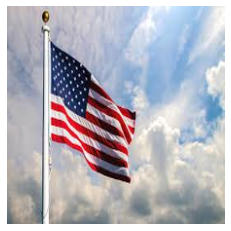

In [9]:
plt.axis("off")
plt.imshow(query_img/255.0)

In [10]:
use_extraction = True
ls_path_score = []

if use_extraction:
    root_features_path = "./feature/all_feartures.npz"
    database = np.load(root_features_path)
    paths_feature = database['array1']
    imgs_feature = database['array2']
    
    FE = FeatureExtractor()
    query_vector = FE.extract(query_img[None, :])
    sim_rates = similarities_metrics[selected_idx](query_vector, imgs_feature)
    ls_path_score = list(zip(paths_feature, sim_rates))

else:
    root_images_path = "./images/"
    dic_categories = ['animal', 'country', 'furniture', 'plant', 'scenery']
    
    for folder in os.listdir(root_images_path):
        if folder.split("_")[0] in dic_categories:
            path = root_images_path + folder
            images_np, images_path = folder_to_images(path)
            rates = similarities_metrics[selected_idx](query_img, images_np)
            ls_path_score.extend(list(zip(images_path, rates)))

In [11]:
m_sample = 15
sort_ls_path_score = sorted(ls_path_score, key=lambda x : x[1], reverse=(selected_idx > 1))[:m_sample]

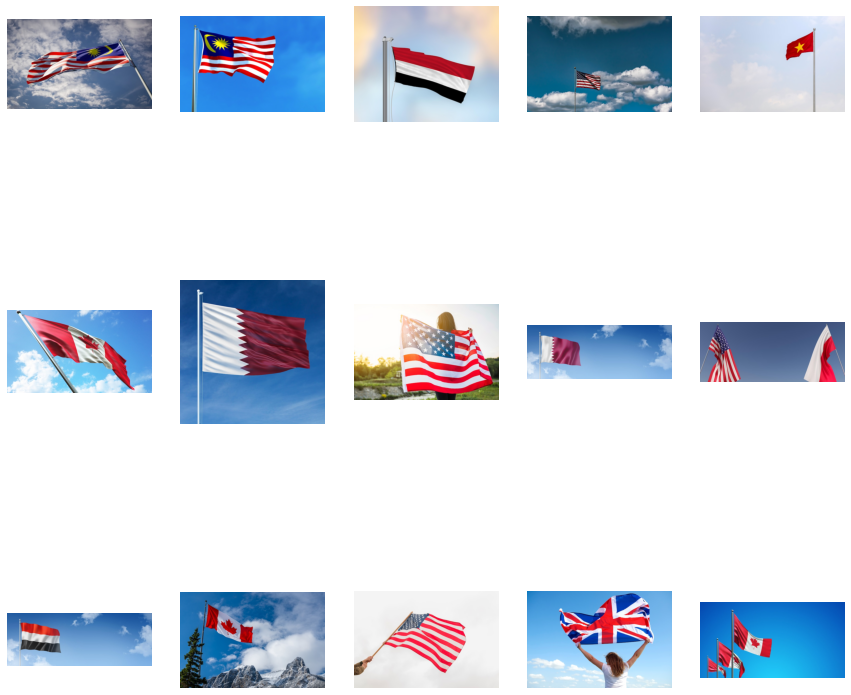

In [12]:
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 3
for i, path in enumerate(sort_ls_path_score, 1):
    img = np.random.randint(10, size=(10,10))
    fig.add_subplot(rows, columns, i)
    plt.imshow(plt.imread(path[0]))
    plt.axis("off")
plt.show()